In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning ---
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Load Data ---
# Load time series or tabular data, parse the date column, and sort by index
df = pd.read_csv("../data/takehome_data.csv", parse_dates=["date"])
df.set_index("date", inplace=True)
df = df.sort_index()


# --- Load Data ---
df = pd.read_csv("../data/takehome_data.csv", parse_dates=["date"])
df.set_index("date", inplace=True)
df = df.sort_index()

In [2]:
# Quick glance at structure and potential issues
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131 entries, 2021-01-02 to 2023-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   131 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


sales    0
dtype: int64

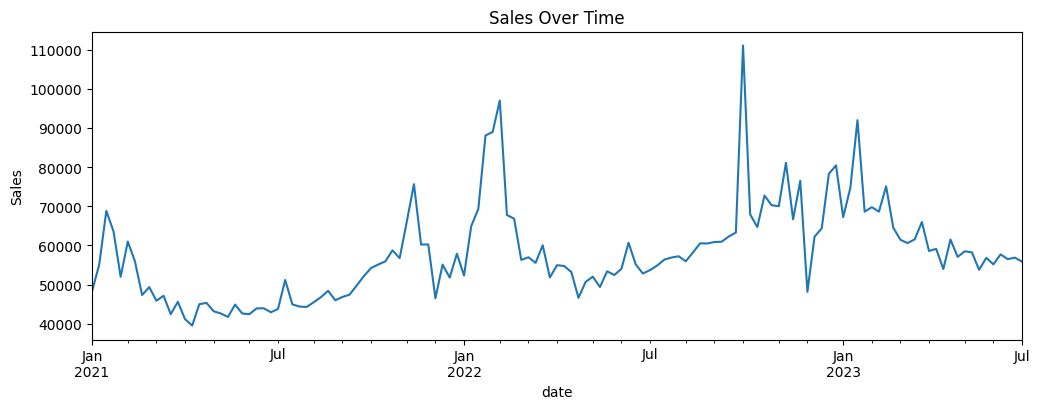

In [3]:
# Plot sales over time
df['sales'].plot(figsize=(12, 4), title="Sales Over Time")
plt.ylabel("Sales")
plt.show()

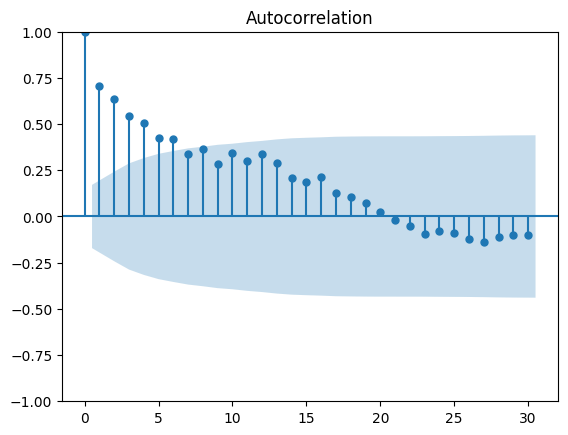

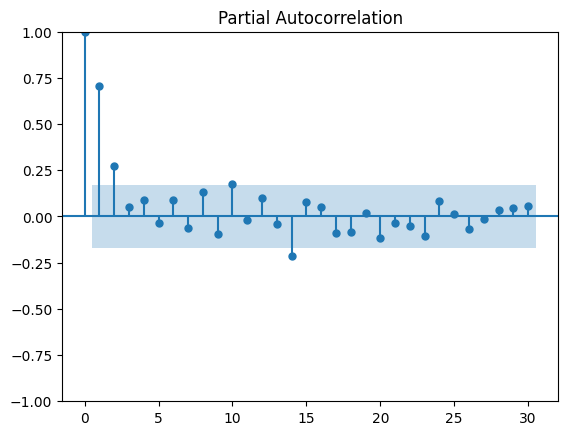

In [4]:
# Check autocorrelation and parital autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df["sales"], lags=30)
plot_pacf(df["sales"], lags=30)
plt.show()

In [5]:
# Add lag features based on autocorrelationa and 
for i in range(1,6):
    col_name = "lag_" + str(i)
    df[col_name] = df["sales"].shift(i)

# rolling averages
df["rolling_3"] = df["sales"].rolling(window=3).mean().shift(1)
df["rolling_7"] = df["sales"].rolling(window=7).mean().shift(1)


# Drop rows with any NaNs caused by shifting or rolling
df = df.dropna()
df

,sales,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_3,rolling_7
date,,,,,,,,
2021-02-20,47341.08,55942.14,61008.81,52006.13,63638.06,68850.32,56319.026667,57828.865714
2021-02-27,49371.61,47341.08,55942.14,61008.81,52006.13,63638.06,54764.010000,57692.708571
2021-03-06,45877.05,49371.61,47341.08,55942.14,61008.81,52006.13,50884.943333,56879.735714
2021-03-13,47153.02,45877.05,49371.61,47341.08,55942.14,61008.81,47529.913333,53597.840000
2021-03-20,42449.10,47153.02,45877.05,49371.61,47341.08,55942.14,47467.226667,51242.834286
...,...,...,...,...,...,...,...,...
2023-06-03,55181.39,56848.10,53782.50,58242.98,58527.58,57086.86,56291.193333,57144.115714
2023-06-10,57727.64,55181.39,56848.10,53782.50,58242.98,58527.58,55270.663333,57313.778571
2023-06-17,56510.76,57727.64,55181.39,56848.10,53782.50,58242.98,56585.710000,56771.007143


In [6]:
# Define features and target
features = ["lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "rolling_3", "rolling_7"]
X = df[features]
y = df["sales"]

# Train-test split with no shuffling to preserve time order
X_train, X_test, y_train, y_test =  train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

In [7]:
# Create and fit the model
model = LinearRegression(
    fit_intercept=True,
    copy_X=True,
    n_jobs=None,
    positive=False
)
model.fit(X_train, y_train)

LinearRegression()

In [8]:
y_pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

MAE: 4156.183682373388
RMSE: 6471.856815942898
R² Score: 0.41505552532930967


In [11]:
import statsmodels.api as sm

# Define your features and target
X = df[[f"lag_{i}" for i in range(1, 6)]].copy()  # or add "rolling_x" features too
y = df["sales"]

# Add constant (bias term) manually — statsmodels doesn't add it automatically
X = sm.add_constant(X)

# Fit the model
ols_model = sm.OLS(y, X).fit()

# Predicted values from the model
y_pred_sm = ols_model.predict(X)

# Residuals = Actual - Predicted
residuals_sm = y - y_pred_sm

# View detailed results
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     30.09
Date:                Sun, 22 Jun 2025   Prob (F-statistic):           1.31e-19
Time:                        21:09:28   Log-Likelihood:                -1291.3
No. Observations:                 124   AIC:                             2595.
Df Residuals:                     118   BIC:                             2611.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.066e+04   4265.947      2.498      0.0

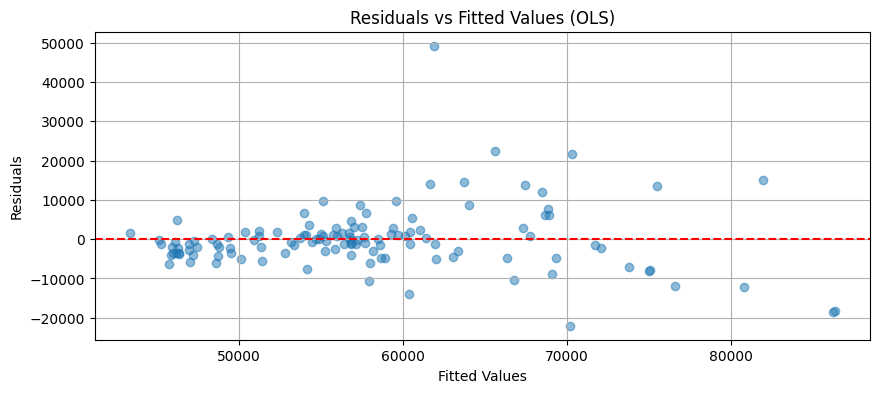

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.scatter(y_pred_sm, residuals_sm, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values (OLS)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

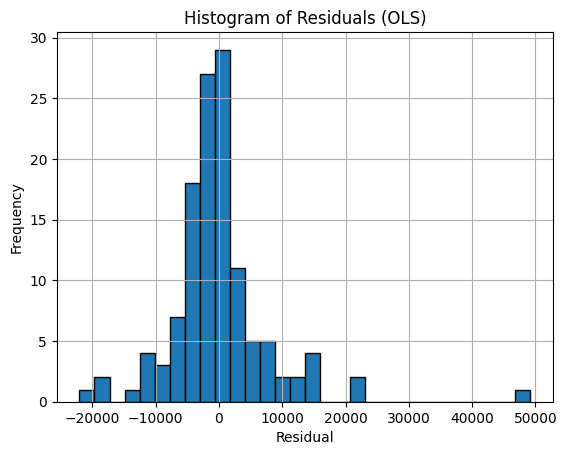

In [13]:
residuals_sm.hist(bins=30, edgecolor="black")
plt.title("Histogram of Residuals (OLS)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()